In [1]:
import pandas as pd
import numpy as np
from collections import Counter
rng = np.random.default_rng(117)

# Read data and get only player names, points per game, and salaries. (Only optimizing for ppg)
data = pd.read_csv("./nbasalariespoints.csv")
data = data[["Player", "PS/G▼", "SALARY"]]
data = data.dropna()

data["PS/G▼"] = data["PS/G▼"].astype(int)
data["SALARY"] = data["SALARY"].str.replace(r"[$,]", "", regex=True).str.strip()
data["SALARY"] = pd.to_numeric(data["SALARY"])
weights = np.array(data["SALARY"].tolist())
values = np.array(data["PS/G▼"].tolist())

In [2]:
# Create a population of num_teams x team_size, with random values from 0-last index
# Each individual represents a team, and each team has 15 players
def initializePopulation(num_teams, team_size, length):
    return rng.integers(0, length, (num_teams, team_size), dtype=int)

def calculateValue(individual, values):
    return np.sum(values[individual])

def calculateWeight(individual, weights):
    return np.sum(weights[individual])

# Sets the fitness to -inf if the weight exceeds the knapsack capacity, or if there are duplicate players (can't draft the same player twice)
# Otherwise, sets the fitness to the value of the team
# Since there is a limit on how many players can be in each team, don't use value to weight ratio as the fitness
def calculateFitness(individual, weights, values, capacity):
    indevidual_weight = calculateWeight(individual, weights)
    count = Counter(individual)
    fitness = calculateValue(individual, values) if indevidual_weight <= capacity else -np.inf
    for i in range(len(individual)):
        if count[individual[i]] > 1: 
            fitness = -np.inf
            break
    return fitness

# Selects the two best as the parents
def selectParents(capacity, weights, values, population):
    fitness = []
    for individual in population:
        fitness.append(calculateFitness(individual, weights, values, capacity))

    fitness = np.array(fitness)
    top_indices = np.argsort(fitness)[-2:] 
    return [population[top_indices[0]], population[top_indices[1]]]

def generatePopulation(parents, size_of_pop, mutation_rate, length):
    num_genes = len(parents[0])
    population = np.zeros((size_of_pop, num_genes), dtype=int)
    population[0], population[1] = parents

    for i in range(2, size_of_pop):
        for j in range(num_genes):
            parent_choice = rng.integers(0, 2)
            population[i][j] = parents[parent_choice][j]
            
            # Mutation
            if rng.random() < mutation_rate:
                population[i][j] = rng.integers(0, length)
    return population


# Saving an invalid solution in the valid list
def knapSackGenetic(capacity, weights, values, training_length, num_teams, team_size):
    length = len(weights) - 1
    population = initializePopulation(num_teams, team_size, length)

    vals = []
    for i in range(training_length):
        vals.append(np.mean([val for val in [calculateValue(ind, values) for ind in population]]))

        parents = selectParents(capacity, weights, values, population)
        population = generatePopulation(parents, num_teams, .01, length)
    
    valid = []
    for individual in population:
        if calculateFitness(individual, weights, values, capacity) == -np.inf: continue
        valid.append(individual)

    valid = np.array(valid)
    indices = np.argsort([val for val in [calculateValue(ind, values) for ind in valid]])
    
    return individual, vals


In [ ]:
capacity = 150_000_000
training_length = 200
num_teams = 50
team_size = 15

individual, vals = knapSackGenetic(capacity, weights, values, training_length, num_teams, team_size)

individual = np.sort(individual)
print(f"Best Solution: {individual}")
print(f"Value: {calculateValue(individual, values)} | Weight: {calculateWeight(individual, weights):,}\n")



Best Solution: [ 0  1  2  5  6  9 10 11 12 17 18 35 47 48 91]
Value: 324 | Weight: 147,322,772



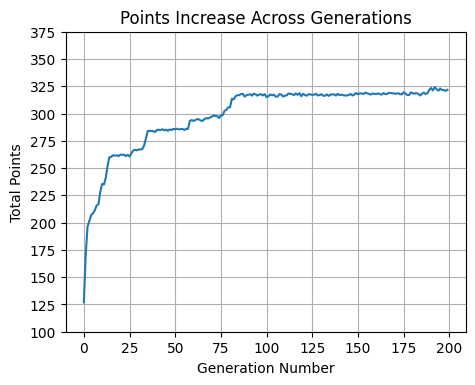

Starting Value: 126.94
Ending Value: 321.74
Max value: 324.16


In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4, 3))
ax = fig.add_axes([0, 0, 1, 1])
vals = vals[:200]
ax.plot(vals)
ax.grid(True)
ax.set_xticks(np.arange(0, len(vals) + 1, 25))
ax.set_yticks(np.arange(100, 400, 25))
ax.set_title("Points Increase Across Generations")
ax.set_ylabel("Total Points")
ax.set_xlabel("Generation Number")
plt.show()
print(f"Starting Value: {vals[0]}")
print(f"Ending Value: {vals[-1]}")
print(f"Max value: {np.max(vals)}")
